## Ejemplo 1: Pruebas A/B

### 1. Objetivos:
    - Aprender a evaluar los resultados de una Prueba A/B
 
---
    
### 2. Desarrollo:

El siguiente es un dataset obtenido con los resultados de una Prueba A/B. Se probaron dos flujos de venta distintos y se registró si cada uno de ellos resultó en una conversión (venta) o no. El test A es la hipótesis alternativa (la aplicada al grupo experimental), mientras que el test B es la hipótesis nula (la aplicada al grupo control).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('../../Datasets/ab_test-sales_pipeline.csv')

df.head()

,test,conversion,no conversion
0,B,0,1
1,A,0,1
2,A,0,1
3,A,0,1
4,A,0,1


Lo primero que podemos hacer es agrupar nuestros resultados por 'test', para realizar un conteo de cuántas conversiones hubo con cada flujo de ventas:

In [7]:
# Agrupamos a todos los que son tratamiento A y todos los que son tratamiento B
# y luego contamos cuantos compraron y cuantos no compraron

total_count = df.groupby('test')[['conversion', 'no conversion']].sum()

total_count

,conversion,no conversion
test,,
A,198,23541
B,184,22404


In [8]:
# Nos dice que 198 personas que recibieron el tratamiento A, sí hicieron una compra
# Nos dice que 184 personas que recibieron el tratamiento B, sí hicieron una compra
# Nos dice que 23541 personas que recibieron el tratamiento A, no hicieron una compra
# Nos dice que 22404 personas que recibieron el tratamiento B, no hicieron una compra

# ¿El tratamiento incentivo la compra?

Saquemos la proporción de conversiones que hubo comparadas con el total de pruebas que se realizaron:

In [10]:
total_count['success rate'] = total_count['conversion'] / (total_count['conversion'] + total_count['no conversion'])

total_count

## 198/(198 + 23541) = 0.008341
## 184/(184 + 22404) = 0.008146

,conversion,no conversion,success rate
test,,,
A,198,23541,0.008341
B,184,22404,0.008146


Con estos datos parecería que el flujo A (la hipótesis alternativa) es superior al flujo B. Veamos qué tan superior:

In [12]:
# Proporcionalmente, ¿qué tan diferentes son las tasas de éxito?
# diferencia_en_proporcion = 1-(0.008146 /0.00834)
diferencia_en_proporcion = 1 - (total_count.loc['B']['success rate'] / total_count.loc['A']['success rate'])
diferencia_en_porcentaje = diferencia_en_proporcion * 100
diferencia_en_porcentaje

2.335377862206267

In [6]:
print(f'El test A fue {diferencia_en_porcentaje:.2f}% más efectivo que el test B para generar ventas.')

El test A fue 2.34% más efectivo que el test B para generar ventas.


¿Ahora, podemos entonces concluir que el flujo de ventas A es mejor que el B? No tan rápido. Vamos a aplicar un test de permutación para saber si nuestro hallazgo es estadísticamente significativo.

Primero tenemos que mezclar las mediciones del test A y el B en el mismo DataFrame. Esto ya está hecho, entonces solamente vamos a eliminar la columna 'test' para que no haya manera de diferenciarlos:

In [13]:
all_measurements = df[['conversion', 'no conversion']]
all_measurements

,conversion,no conversion
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
46322,0,1
46323,0,1
46324,0,1
46325,0,1


Ahora necesitamos saber cuántos tests con el flujo A hubieron para poder generar muestras del mismo tamaño exactamente:

In [15]:
# Recordatorio:

value_counts = df['test'].value_counts() # en nuestro data set original

value_counts

A    23739
B    22588
Name: test, dtype: int64

Ahora vamos a aplicar el resto del algoritmo del test de permutación:

1. Usando muestreo aleatorio sin reposición, construye un nuevo grupo A del mismo tamaño que el original.
2. El resto de los datos conforman nuestro nuevo grupo B.
3. Cuantifica la métrica o estadística que calculaste con los grupos originales y guarda el resultado.
4. Repite los pasos 1-3 `R` veces para obtener una distribución de la estadística de interés.

In [16]:
conv_a = []
no_conv_a = []
conv_b = []
no_conv_b = []

for _ in range(1000):
    a = df.sample(value_counts.loc['A'], replace=False) # a es una muestra de tamño del grupo A
    conv_a.append(a['conversion'].sum())
    no_conv_a.append(a['no conversion'].sum())
    
    # para b no se vuelve a simular, simplemente se toman los índices que no estuvieron 
    # en a
    b = df.loc[~df.index.isin(a.index)] # b es una muestra de tamaño del grupo B
    conv_b.append(b['conversion'].sum())
    no_conv_b.append(b['no conversion'].sum())

In [29]:
b = df.loc[~df.index.isin(a.index)]
b

,test,conversion,no conversion
3,A,0,1
7,B,0,1
8,A,0,1
9,A,0,1
10,A,0,1
...,...,...,...
46313,A,0,1
46318,B,0,1
46320,A,0,1
46322,B,0,1


In [19]:
# meto mis resultados en un dataframe

perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
})

perm_results # tiene mil renglons
# Esta tabla tiene un resumen de cada simulación

,conv_a,no_conv_a,conv_b,no_conv_b
0,179,23560,203,22385
1,182,23557,200,22388
2,206,23533,176,22412
3,203,23536,179,22409
4,195,23544,187,22401
...,...,...,...,...
995,196,23543,186,22402
996,189,23550,193,22395
997,194,23545,188,22400
998,202,23537,180,22408


In [20]:
# ¿Qué hacemos con esta tabla?
# Veremos que proporción compró del trat A y qué proporción compró del trat B

perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

In [21]:
perm_results # qué proporción compró de cada grupo en cada simulación

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate
0,179,23560,203,22385,0.007540,0.008987
1,182,23557,200,22388,0.007667,0.008854
2,206,23533,176,22412,0.008678,0.007792
3,203,23536,179,22409,0.008551,0.007925
4,195,23544,187,22401,0.008214,0.008279
...,...,...,...,...,...,...
995,196,23543,186,22402,0.008256,0.008234
996,189,23550,193,22395,0.007962,0.008544
997,194,23545,188,22400,0.008172,0.008323
998,202,23537,180,22408,0.008509,0.007969


In [22]:
#Volvemos a calcular, qué tan diferetnes son

perm_results['diff'] = 1 - (perm_results['b_conv_rate'] / perm_results['a_conv_rate'])

perm_results

,conv_a,no_conv_a,conv_b,no_conv_b,a_conv_rate,b_conv_rate,diff
0,179,23560,203,22385,0.007540,0.008987,-0.191867
1,182,23557,200,22388,0.007667,0.008854,-0.154897
2,206,23533,176,22412,0.008678,0.007792,0.102096
3,203,23536,179,22409,0.008551,0.007925,0.073295
4,195,23544,187,22401,0.008214,0.008279,-0.007840
...,...,...,...,...,...,...,...
995,196,23543,186,22402,0.008256,0.008234,0.002664
996,189,23550,193,22395,0.007962,0.008544,-0.073199
997,194,23545,188,22400,0.008172,0.008323,-0.018452
998,202,23537,180,22408,0.008509,0.007969,0.063504


Ya tenemos nuestros resultados, vamos a ver dónde cae en nuestra distribución el resultado que obtuvimos en nuestro experimento:

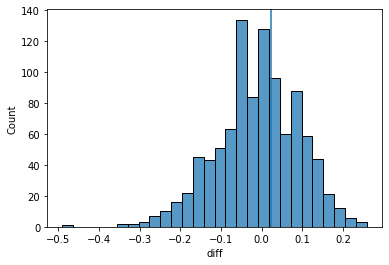

In [25]:
# grafiquemos el histograma de las 1000 diferencias

sns.histplot(perm_results['diff'], kde=False)

plt.axvline(diferencia_en_proporcion) # es el nivel observado (no simulado)

Solamente de ver la histograma podemos concluir que nuestro resultado es de hecho bastante típico. Un gran número de modelos realizados totalmente al azar tuvieron valores iguales o más extremos que el que obtuvimos en nuestro experimento.

Vamos ahora a obtener el Valor P para cuantificar numéricamente nuestro resultado:

In [26]:
# cuantas simulaciones fueron más extremas que la diferencia observada

(perm_results['diff'] >= diferencia_en_proporcion).sum() / perm_results.shape[0]

0.389

Este valor quiere decir que el 38.9% de las simulaciones que hicimos obtuvieron un valor igual o más extremo que el obtenido en el experimento. Esto está extremadamente alejado de un Alfa de 5%, y por lo tanto definitivamente nuestro resultado **no es estadísticamente significativo**.